<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/ale-exp1/ale-exp1_cslg-rand-5000_2w_ale_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description

1-way ALE.

> This notebook is for experiment \<ale-exp1\> and data sample \<cslg-rand-5000\>.

### Initialization

In [69]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/ale-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [70]:
sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd
from getting_data import read_conf

sample_name = 'cslg-rand-5000'

f_list = [
    'title', 
    'abstract', 
    'venue', 
    # 'authors', 
    'year', 
    'n_citations'
    ]
ale_rs = []
ale_metric = pd.DataFrame(columns=['f1_name', 'f2_name', 'mean', 'var', 'std'])

def replace_quantile(feature_name, quantile):
    if feature_name == 'year' or feature_name == 'n_citations':
        return quantile
    else:
        return list(range(len(quantile)))
    
def norm(arr):
  if np.mean(arr) != 0:
    norm = np.linalg.norm(arr)
    arr = arr / norm
    
  return arr

mean_arr = []
var_arr = []
std_arr = []

for i in range(len(f_list)):
    f1_name = f_list[i]
    for j in range(i + 1, len(f_list)):
        f2_name = f_list[j]
        file = os.path.join('.', 'scores', f'{sample_name}_2w_ale_{f1_name}_{f2_name}.npz')
        if os.path.exists(file):
            nparr = np.load(file)
            quantile_1 = nparr['quantile_1']
            quantile_2 = nparr['quantile_2']
            ale_result = nparr['ale_result']
            
            mean_arr.append(np.mean(ale_result))
            var_arr.append(np.var(ale_result, ddof=1))
            std_arr.append(np.std(ale_result, ddof=1))
            
            t = f'The mean of the 2-way ale - ({f1_name} * {f2_name})'
            
            ale = {
                'ale': norm(ale_result),
                'f1_quantile': replace_quantile(f1_name, quantile_1),
                'f2_quantile': replace_quantile(f2_name, quantile_2),
                'f1_name': f1_name,
                'f2_name': f2_name,
                'title': t
            }
            
            ale_rs.append(ale)
            
mean_arr = norm(mean_arr) 
var_arr = norm(var_arr) 
std_arr = norm(std_arr)

pd.options.display.float_format = '{:,.40f}'.format
pd.set_option('display.expand_frame_repr', False)

idx = 0
for i in range(len(f_list)):
    f1_name = f_list[i]
    for j in range(i + 1, len(f_list)):
        f2_name = f_list[j]
        ale_metric.loc[len(ale_metric.index)] = [f1_name, f2_name, mean_arr[idx], var_arr[idx], std_arr[idx]]
        idx += 1

print(ale_metric.sort_values(by=['std'], ascending=False))


    f1_name      f2_name                                        mean                                        var                                        std
9      year  n_citations  0.9999999999980946352451383063453249633312 1.0000000000000000000000000000000000000000 0.9999999999982027709677367965923622250557
5  abstract         year  0.0000019521200761748029277992642904759890 0.0000000000035945394242884104267677165799 0.0000018959270619608472193643334408053036
2     title         year  0.0000000000000000007408915836933972759566 0.0000000000000000000000000000000000004255 0.0000000000000000006522736812113871271119
6  abstract  n_citations  0.0000000000000000000462969974711885298632 0.0000000000000000000000000000000000000022 0.0000000000000000000466039467431695903014
0     title     abstract -0.0000000000000000000000257882416463301550 0.0000000000000000000000000000000000000000 0.0000000000000000000000251253294477478557
3     title  n_citations -0.0000000000000000000000000002308501499127 0

### ALE Plots

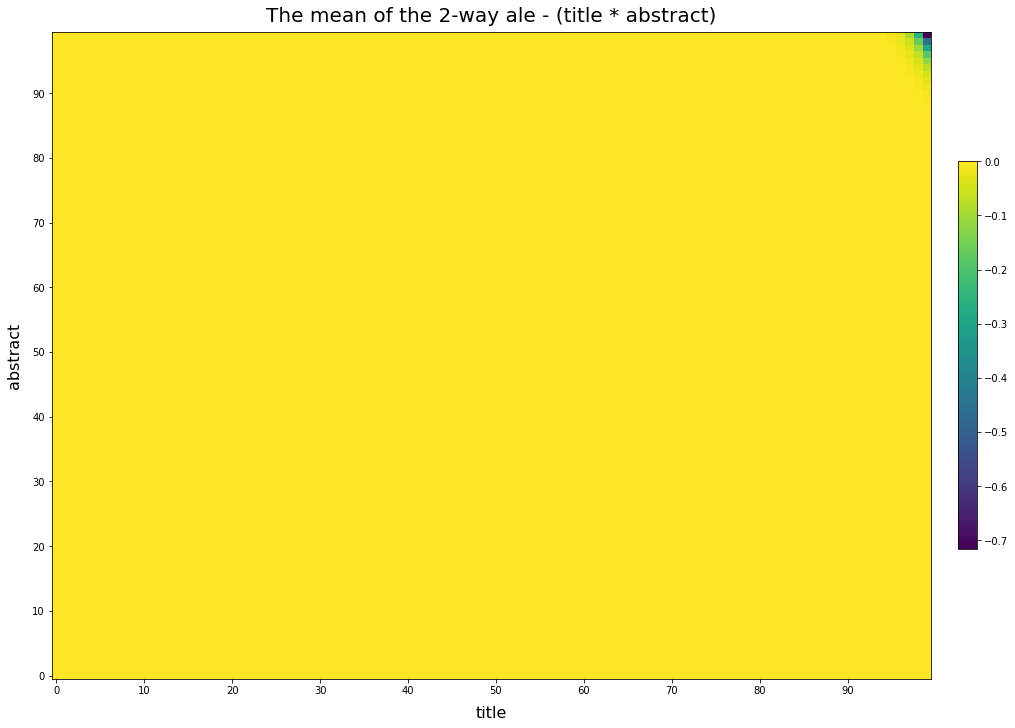

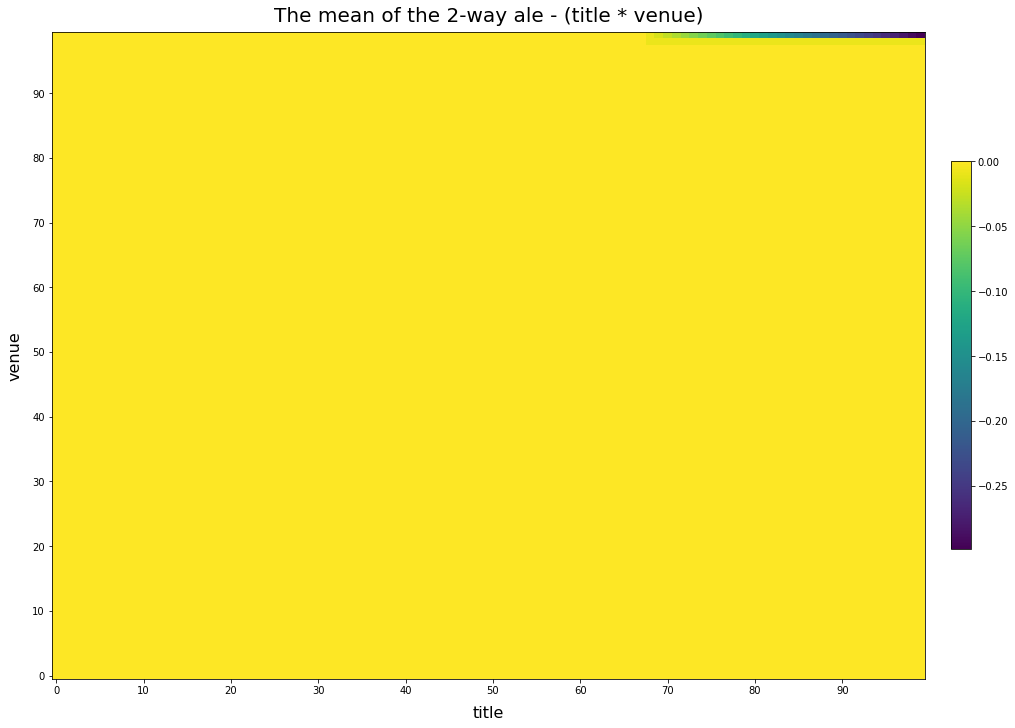

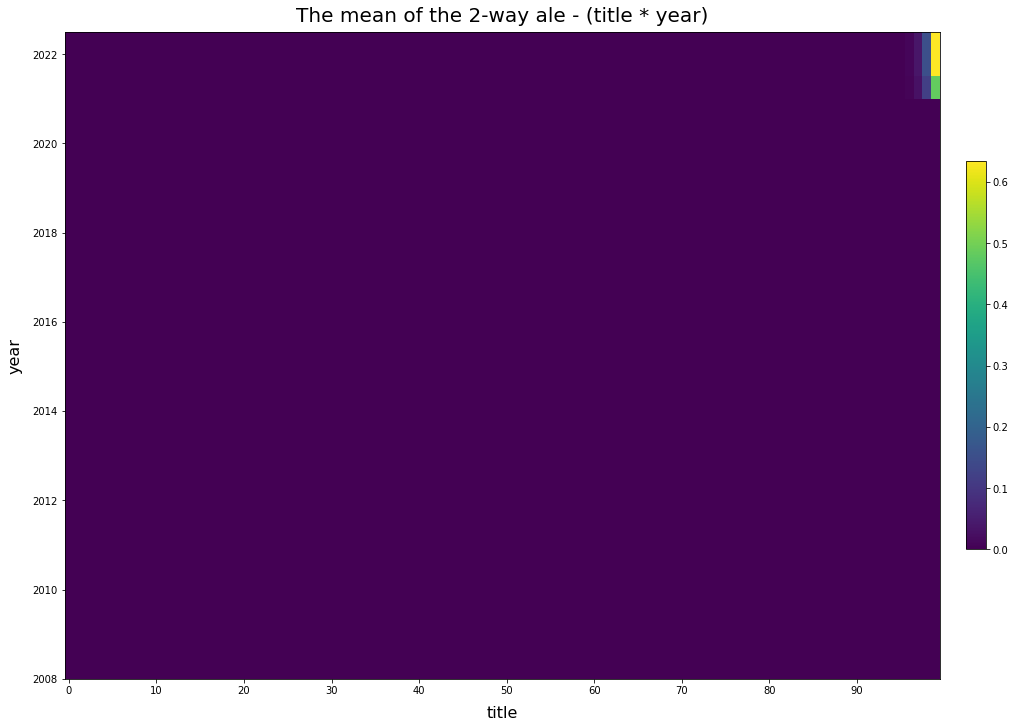

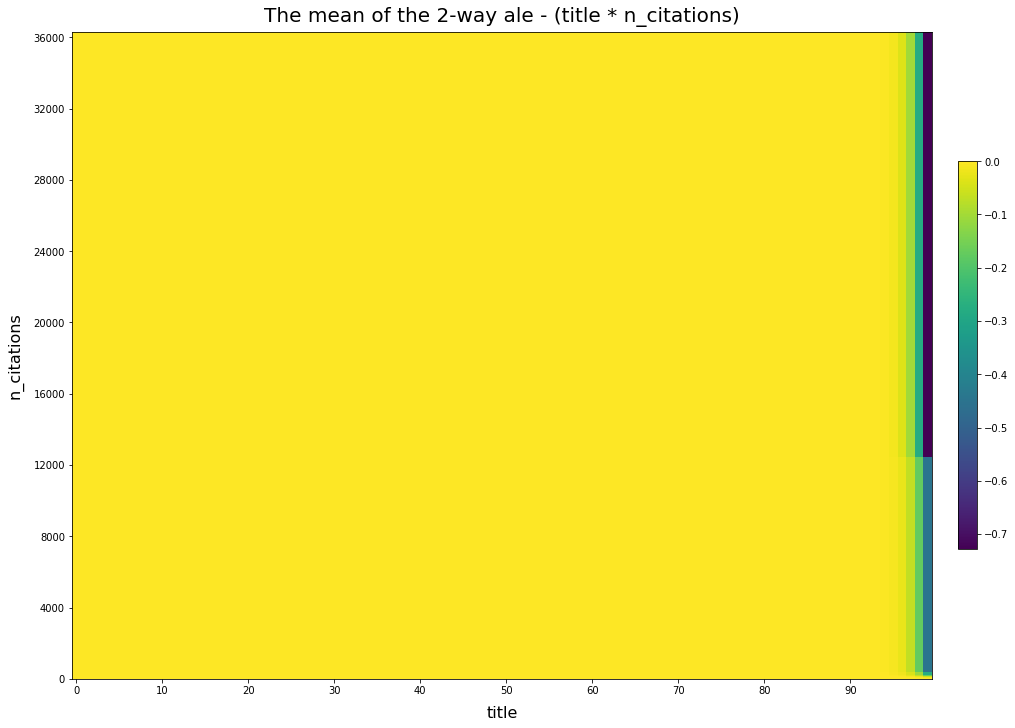

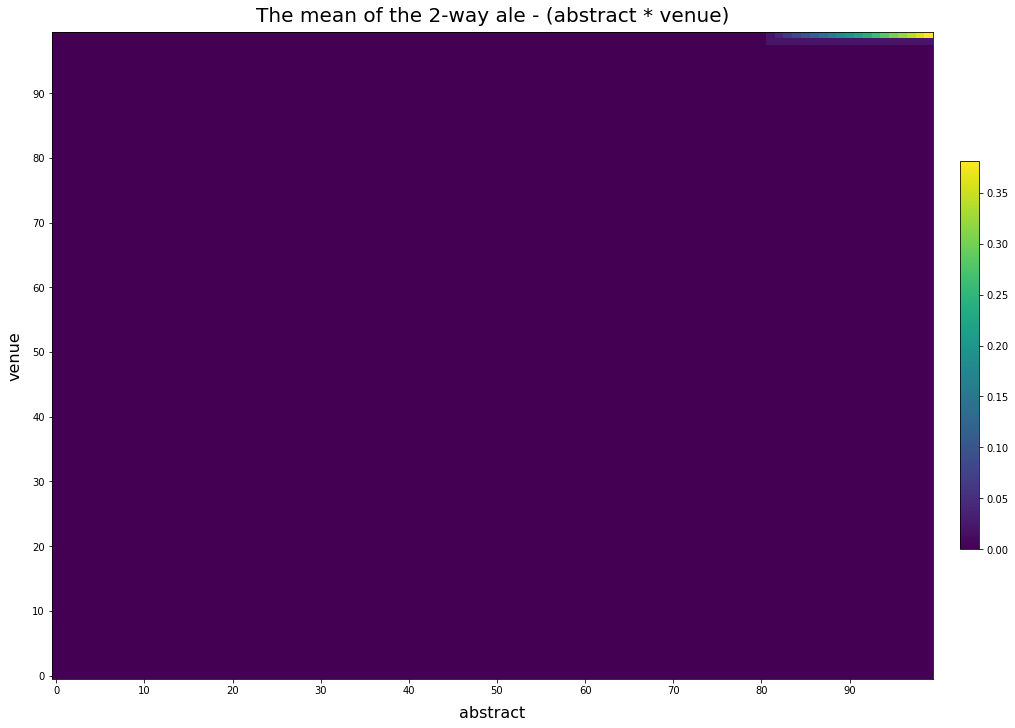

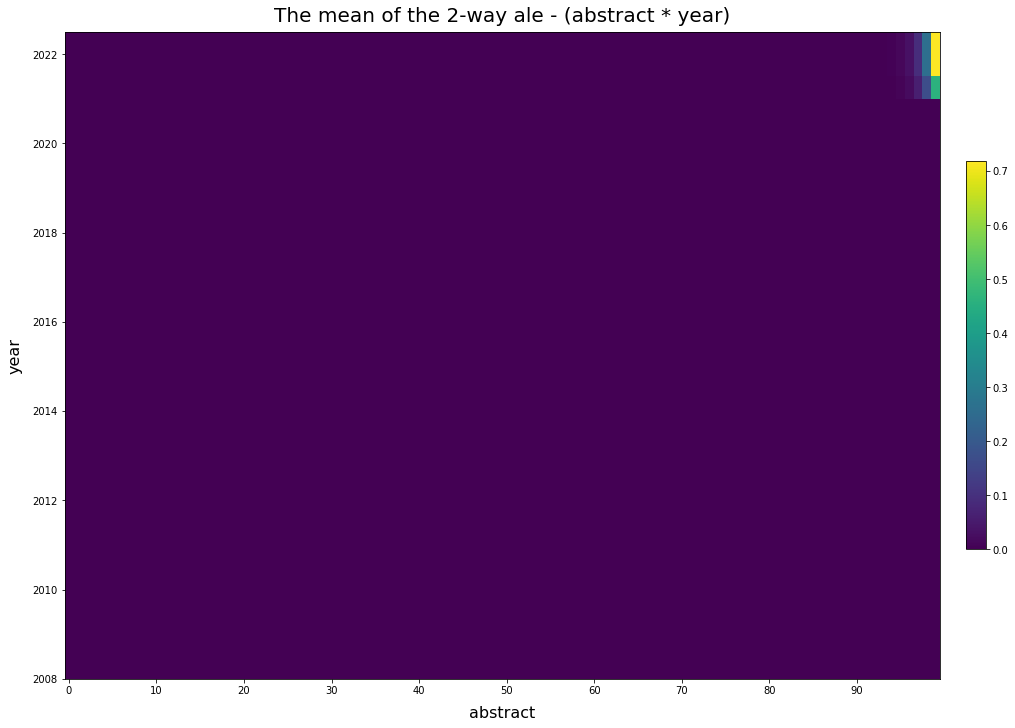

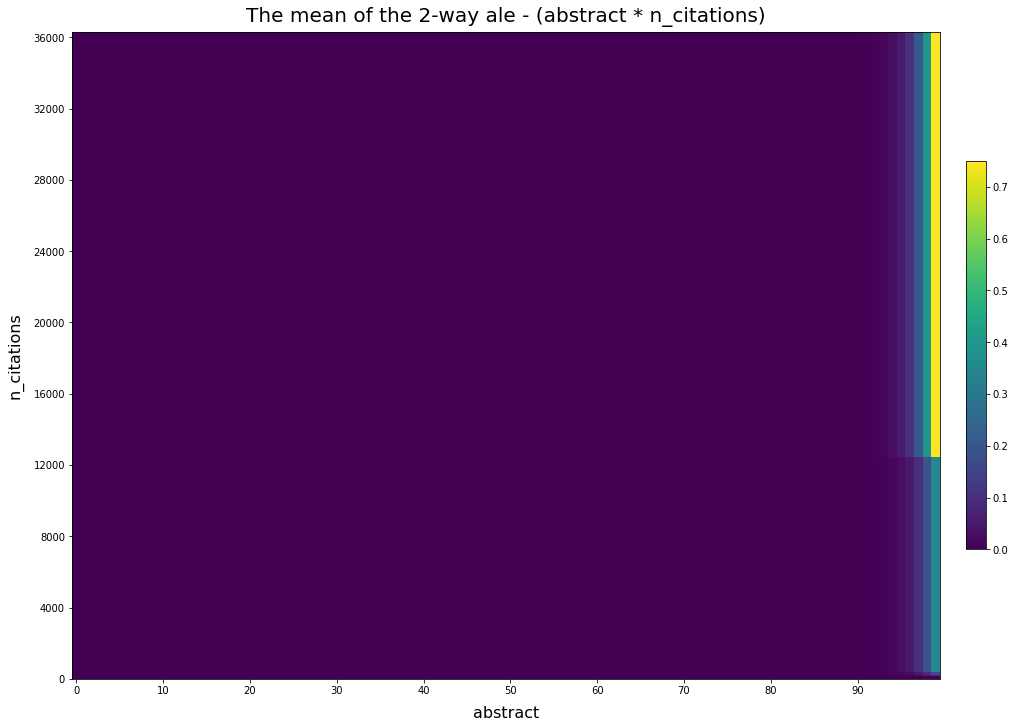

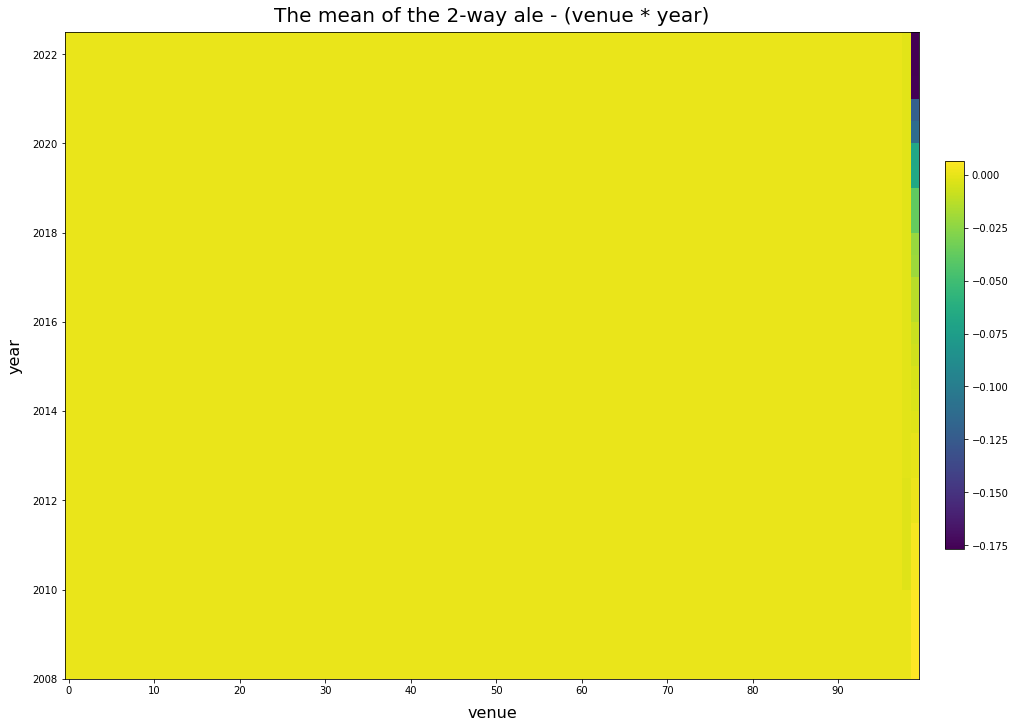

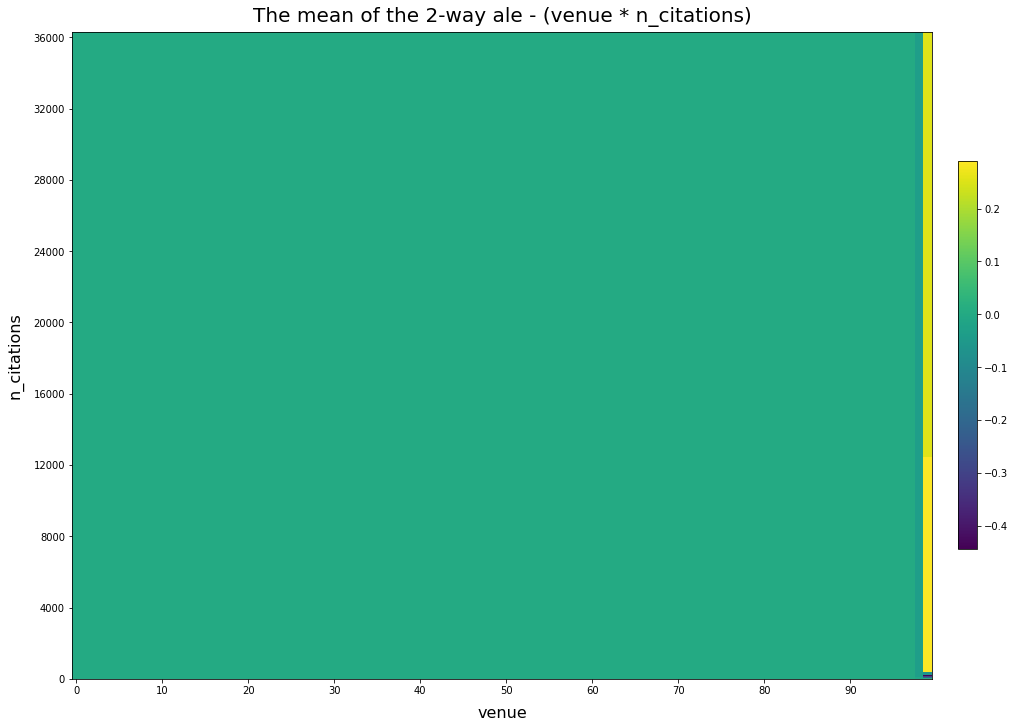

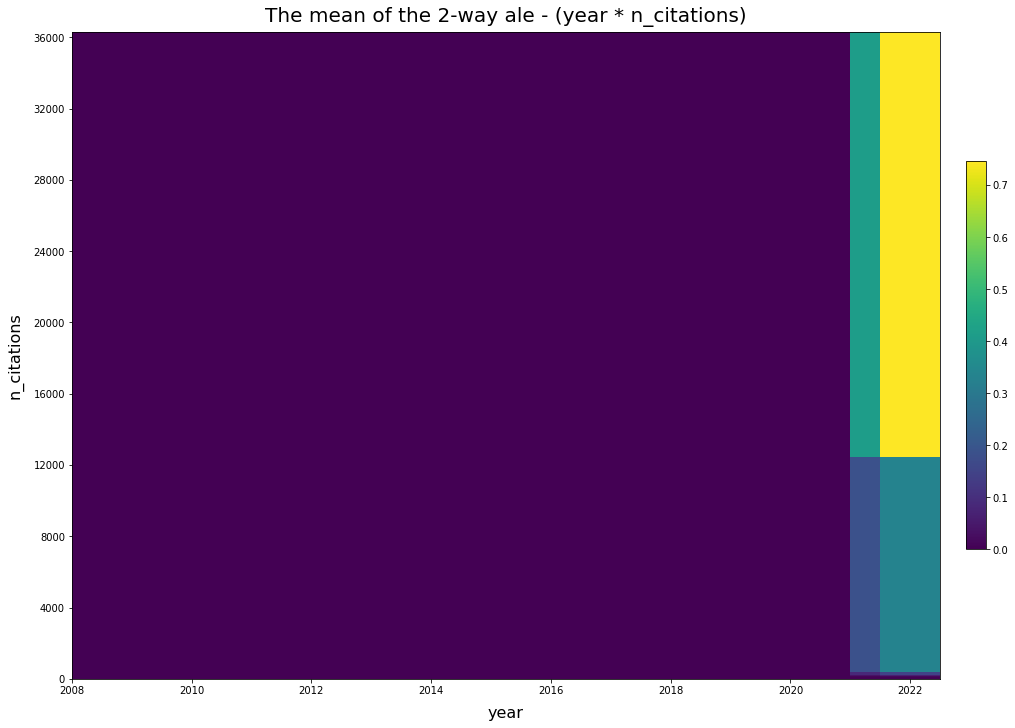

In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

for ale in ale_rs:
    fig, ax = plt.subplots(figsize=(14, 10), constrained_layout=True)
    cmap = plt.colormaps['BuGn']
    
    im = ax.pcolormesh(ale['f1_quantile'], ale['f2_quantile'], ale['ale'],  cmap=None, edgecolors='k', linewidths=0)

    # cf = ax.contourf(ale['f1_quantile'], ale['f2_quantile'], ale['ale'], levels=50, alpha=0.7)
    
    ax.set_xlabel(ale['f1_name'], fontsize=16, labelpad=10)
    ax.set_ylabel(ale['f2_name'], fontsize=16, labelpad=10)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(ale['title'], fontsize=20, pad=10)
    fig.colorbar(im, ax=ax, shrink=0.6, pad=0.03)
    plt.savefig(os.path.join('.', 'plot', f"{sample_name}-2wale-{ale['f1_name']}-{ale['f2_name']}.png"), facecolor='white', transparent=False, bbox_inches='tight')
